# BE 2 Data Science : Moteurs de Recherche

### Importation des Librairies

In [44]:
import json
import numpy as np
import networkx as nx
from collections import defaultdict, Counter
from typing import Dict, List, Tuple
import os
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

from scipy.sparse import find, csr_matrix
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import norm
from IPython.core.display import HTML

import pandas as pd

# For embeddings and similarity computation 
try:
    from sentence_transformers import SentenceTransformer
    from sklearn.metrics.pairwise import cosine_similarity
    print("Required libraries imported successfully!")
except ImportError as e:
    print(f"Missing library: {e}")
    print("Please install with: pip install sentence-transformers scikit-learn networkx")

np.random.seed(42)

Required libraries imported successfully!


## Analyse des données

In [45]:
# des options permettent de limiter (ou non) le nombre de lignes/colonnes affichées
# par exemple :
# pd.set_option('display.max_rows', None)

# cette fonction permet d'afficher une "jolie" représentation du vecteur v
# ARGS :
#   v : le vecteur à afficher (par ex. une ligne de la matrice X)
#   features : le vocabulaire
#   top_n : le nombre de mots maximum à afficher
def print_feats(v, features, top_n = 30):
    _, ids, values = find(v)
    feats = [(ids[i], values[i], features[ids[i]]) for i in range(len(list(ids)))]
    top_feats = sorted(feats, key=lambda x: x[1], reverse=True)[0:top_n]
    return pd.DataFrame({"word" : [t[2] for t in top_feats], "value": [t[1] for t in top_feats]})   

# fonction qui permet d'afficher plusieurs tables pandas côte à côte (c'est cadeau)
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "&emsp;"
        #output += "\xa0\xa0\xa0"
    display(HTML(output))

In [46]:
def load_corpus(file_path: str) -> Dict[str, Dict]:
    corpus = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            doc = json.loads(line)
            doc_id = doc.pop('_id')
            corpus[doc_id]=doc
    return corpus

def load_queries(file_path: str) -> Dict[str, Dict]:
    queries = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            query = json.loads(line)
            query_id = query.pop("_id")
            queries[query_id] = query
    return queries

def load_qrels(file_path: str) -> Dict[str, Dict[str, int]]:
    qrels = defaultdict(dict)
    df = pd.read_csv(file_path, sep='\t', header=0)
    for _, row in df.iterrows():
        qrels[str(row['query-id'])][str(row['corpus-id'])] = int(row['score'])
    return dict(qrels) 

# Load the dataset
corpus = load_corpus('data/corpus.jsonl')
queries = load_queries('data/queries.jsonl')
qrels_valid = load_qrels('data/valid.tsv')

print(f"exemple de document : {list(corpus.items())[0]}")
print(f"exemple de query : {list(queries.items())[0]}")
print(f"exemple de candidats et leur score pour une requête donné :{list(qrels_valid.items())[0]}\n")

print(f"Loaded {len(corpus)} documents in corpus")
print(f"Loaded {len(queries)} queries")
print(f"Loaded relevance for {len(qrels_valid)} queries")

exemple de document : ('632589828c8b9fca2c3a59e97451fde8fa7d188d', {'title': 'A hybrid of genetic algorithm and particle swarm optimization for recurrent network design', 'text': 'An evolutionary recurrent network which automates the design of recurrent neural/fuzzy networks using a new evolutionary learning algorithm is proposed in this paper. This new evolutionary learning algorithm is based on a hybrid of genetic algorithm (GA) and particle swarm optimization (PSO), and is thus called HGAPSO. In HGAPSO, individuals in a new generation are created, not only by crossover and mutation operation as in GA, but also by PSO. The concept of elite strategy is adopted in HGAPSO, where the upper-half of the best-performing individuals in a population are regarded as elites. However, instead of being reproduced directly to the next generation, these elites are first enhanced. The group constituted by the elites is regarded as a swarm, and each elite corresponds to a particle within it. In this 

In [47]:
# Statistiques
# Nombre total de paires (requête, candidat)
total_pairs = sum(len(c) for c in qrels_valid.values())
# Nombre total de documents pertinents (score = 1)
total_relevant = sum(sum(c.values()) for c in qrels_valid.values())
# Nombre total de documents non pertinents (score = 0)
total_non_relevant = total_pairs - total_relevant

# Proportions
prop_relevant = total_relevant / total_pairs
prop_non_relevant = total_non_relevant / total_pairs

print("\nStatistiques des données d'évaluation")
print(f"Taille du corpus : {len(corpus)} articles")
print(f"Nombre de requêtes : {len(queries)} (dans queries.jsonl) dont {len(qrels_valid)} avec évaluation disponible (valid.tsv)")
print(f"Nombre total de paires (requête, candidat) : {total_pairs}")
print(f"Proportion de documents pertinents : {prop_relevant:.2f}")
print(f"Proportion de documents non pertinents : {prop_non_relevant:.2f}")

# Exemple de requête
query_id = list(qrels_valid.keys())[1] # Prendre la deuxième requête
q_doc = queries.get(query_id)
print("\nExemple de Requête")
print(f"Requête ID: {query_id}")
print(f"Titre de la Requête (Q): {q_doc['text']}")

# Séparer les candidats pertinents (positifs) des non pertinents (négatifs)
positive_candidates = [doc_id for doc_id, score in qrels_valid[query_id].items() if score == 1]
negative_candidates = [doc_id for doc_id, score in qrels_valid[query_id].items() if score == 0]
# Afficher les exemples positifs
print("\nCorrespondances Positives :")
for doc_id in positive_candidates:
    doc = corpus[doc_id]
    print(f"  - {doc_id}: {doc['title']}")
# Afficher quelques exemples négatifs
print("\nExemples de Correspondances Négatives :")
for i, doc_id in enumerate(negative_candidates[:5]):
    doc = corpus[doc_id]
    print(f"  - {doc_id}: {doc['title']}")


Statistiques des données d'évaluation
Taille du corpus : 25657 articles
Nombre de requêtes : 1000 (dans queries.jsonl) dont 700 avec évaluation disponible (valid.tsv)
Nombre total de paires (requête, candidat) : 20950
Proportion de documents pertinents : 0.16
Proportion de documents non pertinents : 0.84

Exemple de Requête
Requête ID: 2dbe49d7c9a65656cd46d22ea07dc317b26482b6
Titre de la Requête (Q): Development of 50-kV 100-kW Three-Phase Resonant Converter for 95-GHz Gyrotron

Correspondances Positives :
  - b86ff05be068c362598ab65c70e4488d0b23bc37: Compact and high repetitive pulsed power modulator based on semiconductor switches
  - ac27345da3151b523a3c6e5a81e9b23189638c92: Solid state Marx Generator using series-connected IGBTs
  - 1a387b6b35e0dde559135d65a4502d626a5a8320: Industrial Applications of Pulsed Power Technology
  - 752dcdf42eddc2421c5a07980f8fa65f11a2fed8: A Hybrid Symmetrical Voltage Multiplier
  - 632bba9b4c7136405978dadf618e9e317869a3e0: Design and Implementation o

## Approches creuses (TF - TF/IDF)

In [48]:
# Préparer les titres pour la vectorisation
corpus_ids = list(corpus.keys())
id_to_index = {doc_id: i for i, doc_id in enumerate(corpus_ids)}
corpus_titles = [corpus[doc_id]['title'] for doc_id in corpus_ids]

# Initialiser et entraîner (fit) le vectoriseur
vectorizer = CountVectorizer(stop_words="english")
vectorizer = vectorizer.fit(corpus_titles)

# Créer la matrice documents x termes
X = vectorizer.transform(corpus_titles)

# Récupérer le vocabulaire
features = vectorizer.get_feature_names_out()
# print(features)
print(f"exemples de mots présents dans le corpus : {vectorizer.vocabulary_}")
print(f"Matrice Documents x Termes (X) de taille : {X.shape}")
print(f"Taille du vocabulaire : {len(features)} mots")

exemples de mots présents dans le corpus : {'hybrid': 8536, 'genetic': 7573, 'algorithm': 942, 'particle': 13043, 'swarm': 17496, 'optimization': 12624, 'recurrent': 14867, 'network': 12015, 'design': 5028, 'ep': 6242, 'sqp': 16861, 'dynamic': 5695, 'economic': 5796, 'dispatch': 5351, 'nonsmooth': 12245, 'fuel': 7382, 'cost': 4221, 'function': 7390, 'fuzzy': 7422, 'systems': 17598, 'evolutionary': 6446, 'tuning': 18519, 'learning': 9997, 'knowledge': 9762, 'bases': 1954, 'modified': 11367, 'optimizer': 12628, 'identification': 8676, 'control': 4068, 'using': 18908, 'neural': 12021, 'networks': 12018, 'separate': 16053, 'face': 6682, 'body': 2393, 'selectivity': 15973, 'fusiform': 7412, 'gyrus': 7975, 'scheduling': 15761, 'reduced': 14886, 'cpu': 4281, 'energy': 6151, 'data': 4628, 'mining': 11230, 'approach': 1330, 'location': 10278, 'prediction': 13923, 'mobile': 11328, 'environments': 6233, 'mathsf': 10739, 'pscan': 14298, 'fast': 6778, 'exact': 6457, 'structural': 17163, 'graph': 78


Exemple de vecteur de document (top 10 mots) :
Text : Shape-aware Instance Segmentation


,word,value
0,aware,1
1,instance,1
2,segmentation,1
3,shape,1



Distribution des mots les plus fréquents :


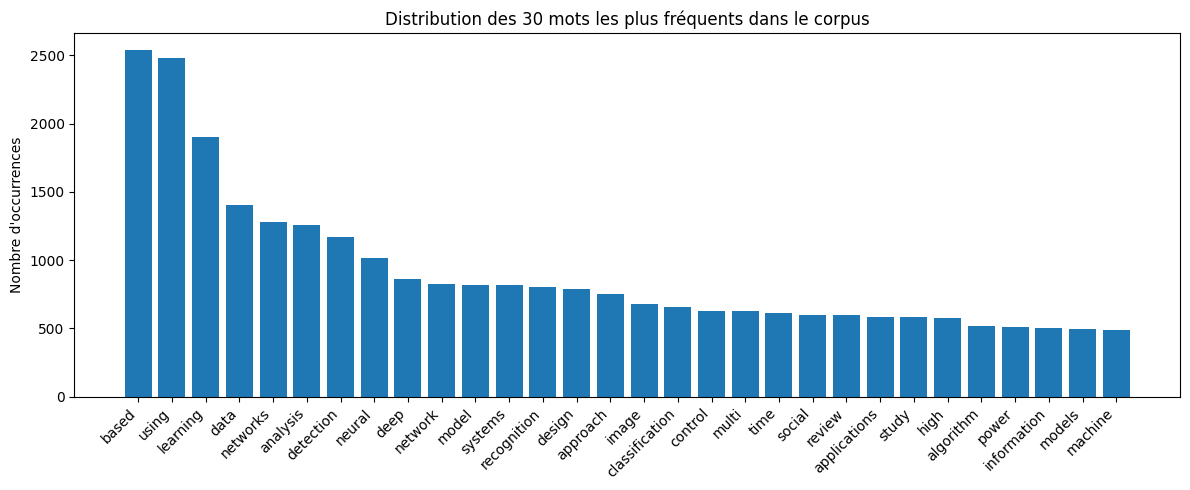

In [49]:
# Afficher des exemples de vecteurs
print("\nExemple de vecteur de document (top 10 mots) :")
doc_index_example = 42 # Le premier document du corpus
v_example = X[doc_index_example]
print(f"Text : {corpus_titles[doc_index_example]}")
display(print_feats(v_example, features, top_n = 10).style.set_caption("Vecteur du 1er document (CountVectorizer)"))

# Distribution des mots les plus fréquents (dans tout le corpus)
print("\nDistribution des mots les plus fréquents :")

# Calculer la somme des occurrences par colonne (par terme)
term_counts = X.sum(axis=0) 
term_counts_sparse = csr_matrix(term_counts)

# Afficher les 30 mots les plus fréquents dans le corpus
top_terms_df = print_feats(term_counts_sparse, features, top_n=30)

# Affichage de l'histogramme
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.bar(top_terms_df['word'], top_terms_df['value'])
plt.xticks(rotation=45, ha='right')
plt.title('Distribution des 30 mots les plus fréquents dans le corpus')
plt.ylabel('Nombre d\'occurrences')
plt.tight_layout()
plt.show()

In [50]:
# Choisir une requête et des candidats
query_id_example = list(qrels_valid.keys())[42] 
q_doc_ex = queries.get(query_id_example)

# Choisir un positif et un négatif
pos_doc_id = [doc_id for doc_id, score in qrels_valid[query_id_example].items() if score == 1][0]
neg_doc_id = [doc_id for doc_id, score in qrels_valid[query_id_example].items() if score == 0][0]

pos_doc = corpus[pos_doc_id]
neg_doc = corpus[neg_doc_id]

# Encodage des titres
titles_to_compare = [q_doc_ex['text'], pos_doc['title'], neg_doc['title']]
X_compare = vectorizer.transform(titles_to_compare)

# Calculer la similarité pour les 2 candidats
sim_Q_C_pos = cosine_similarity(X_compare[0], X_compare[1])[0][0]
sim_Q_C_neg = cosine_similarity(X_compare[0], X_compare[2])[0][0]

print(f"\nRequête (Q): {q_doc_ex['text']}")
print(f"Candidat Positif (C+): {pos_doc['title']}")
print(f"Candidat Négatif (C-): {neg_doc['title']}")

print(f"\nScore d'appariement S(Q, C+) : {sim_Q_C_pos}")
print(f"Score d'appariement S(Q, C-) : {sim_Q_C_neg}")


Requête (Q): A Compact Size, Multi Octave Bandwidth Power Amplifier, Using LDMOS Transistors
Candidat Positif (C+): 10W ultra-broadband power amplifier
Candidat Négatif (C-): Signal-Quality Indices for the Electrocardiogram and Photoplethysmogram: Derivation and Applications to Wireless Monitoring

Score d'appariement S(Q, C+) : 0.282842712474619
Score d'appariement S(Q, C-) : 0.0


In [51]:
def retrieve_top_k(query_id : str, model, transformed_corpus, queries = queries, corpus = corpus,  k: int = 10, dense = True) -> pd.DataFrame:
    """
    Implémente le moteur de recherche basé sur les embeddings (approche dense).
    """

    query_text = queries[query_id].get('text')
    id_candidates = list(qrels_valid[query_id].keys())
    index_candidates = [id_to_index[doc] for doc in id_candidates]
    
    if dense : 
        # Encodage de la requête
        q_embedding = model.encode([query_text], convert_to_numpy=True)
        # Utilisation de la similarité cosinus entre le vecteur requête et la matrice du corpus
        c_embedding = transformed_corpus[index_candidates]
        scores = cosine_similarity(q_embedding, c_embedding).flatten()

    else : 
        # Construire le vecteur requête (q)
        q_vec = model.transform([query_text])
        # Construire le vecteur des candidats 
        c_vec = transformed_corpus[index_candidates]
        # Calculer le score S(q, c) pour tous les documents c du corpus
        scores = cosine_similarity(q_vec, c_vec).flatten()
    
    # Trier les résultats
    top_k_indices = np.argsort(scores)[::-1][:k]

    # Construire le résultat avec la pertinence réelle
    results = []
    for rank, idx in enumerate(top_k_indices):
        doc_id = id_candidates[idx]
        doc = corpus[doc_id]
        results.append({
            'Rank': rank + 1,
            'Document ID': doc_id,
            'Title': doc['title'],
            'Cosine Similarity': scores[idx],
            'Truth on validation' : qrels_valid[query_id][doc_id]
        })

    return pd.DataFrame(results)

# Tester le moteur
query_id = list(qrels_valid.keys())[42] 
q_doc = queries.get(query_id)
query_example_text = q_doc['text']

print(f"Requête : {query_example_text}")

top_results_df = retrieve_top_k(query_id, vectorizer, X, queries, corpus,  k=10, dense = False)
display(top_results_df.style.hide(axis = 'index').set_caption("Résultats Top 7 (CountVectorizer)"))


Requête : A Compact Size, Multi Octave Bandwidth Power Amplifier, Using LDMOS Transistors


Rank,Document ID,Title,Cosine Similarity,Truth on validation
1,f7363d2ac142bcb66cdb481a70e7c9c5c60771dd,10W ultra-broadband power amplifier,0.282843,1
2,112d7ba8127dd340ed300e3efcb2fccd345f231f,A 100 watts L-band power amplifier,0.282843,1
3,be25b709e788a86be9ef878e9b60f7a7527e0d24,100 W GaN HEMT power amplifier module with > 60% efficiency over 100–1000 MHz bandwidth,0.253546,1
4,583db69db244b8ddda81367bf41bb8c4419ed248,RF power amplifiers for wireless communications,0.141421,1
5,b6ba896ba86b8853fdbe02787fef9ade745a2cfe,Teaching Computer Organization and Architecture Using Simulation and FPGA Applications,0.111803,0
6,128e1d5ef2fe666c6ae88ce5ffe97005a40b157b,A design methodology for the realization of multi-decade baluns at microwave frequencies,0.111803,1
7,d3e1081e173cec3ee08cb123506c4402267345c8,Predicting Neural Activity Patterns Associated with Sentences Using a Neurobiologically Motivated Model of Semantic Representation.,0.091287,0
8,e3640b779d2ff35aabfb0a529089b1df5457275f,Charging algorithms of lithium-ion batteries: An overview,0.000000,0
9,614399e28cbc5ec2b3540de8a7acfb9c46c0de5e,"Heart rate variability reflects self-regulatory strength, effort, and fatigue.",0.000000,0
10,c5212a90571a887f5841ce7aea0ba3fa26237ba2,Evaluation of Three Methods for MRI Brain Tumor Segmentation,0.000000,0


In [52]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_vectorizer = tfidf_vectorizer.fit(corpus_titles)
X_tfidf=tfidf_vectorizer.transform(corpus_titles)
tfidf_features = tfidf_vectorizer.get_feature_names_out()

# Tester le moteur avec TFIDF
top_results_tfidf_df = retrieve_top_k(query_id, tfidf_vectorizer, X_tfidf, queries, corpus, k=10, dense = False)
print(f"Requête : {query_example_text}")
display(top_results_tfidf_df.style.hide(axis = 'index').set_caption("Résultats Top 7 (TFIDF)"))

Requête : A Compact Size, Multi Octave Bandwidth Power Amplifier, Using LDMOS Transistors


Rank,Document ID,Title,Cosine Similarity,Truth on validation
1,f7363d2ac142bcb66cdb481a70e7c9c5c60771dd,10W ultra-broadband power amplifier,0.188160,1
2,112d7ba8127dd340ed300e3efcb2fccd345f231f,A 100 watts L-band power amplifier,0.188100,1
3,be25b709e788a86be9ef878e9b60f7a7527e0d24,100 W GaN HEMT power amplifier module with > 60% efficiency over 100–1000 MHz bandwidth,0.184766,1
4,583db69db244b8ddda81367bf41bb8c4419ed248,RF power amplifiers for wireless communications,0.072205,1
5,128e1d5ef2fe666c6ae88ce5ffe97005a40b157b,A design methodology for the realization of multi-decade baluns at microwave frequencies,0.045081,1
6,b6ba896ba86b8853fdbe02787fef9ade745a2cfe,Teaching Computer Organization and Architecture Using Simulation and FPGA Applications,0.027911,0
7,d3e1081e173cec3ee08cb123506c4402267345c8,Predicting Neural Activity Patterns Associated with Sentences Using a Neurobiologically Motivated Model of Semantic Representation.,0.020959,0
8,e3640b779d2ff35aabfb0a529089b1df5457275f,Charging algorithms of lithium-ion batteries: An overview,0.000000,0
9,614399e28cbc5ec2b3540de8a7acfb9c46c0de5e,"Heart rate variability reflects self-regulatory strength, effort, and fatigue.",0.000000,0
10,c5212a90571a887f5841ce7aea0ba3fa26237ba2,Evaluation of Three Methods for MRI Brain Tumor Segmentation,0.000000,0


In [53]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

def evaluate_research_method(model, transformed_corpus, dense = False, qrels_valid = qrels_valid, queries=queries, corpus = corpus) -> Dict:
    """
    Évalue le moteur de recherche dense sur l'ensemble de validation.
    """
    all_y_true = []
    all_y_score = []

    # Itérer sur chaque requête dans le jeu de validation
    for qid in list(qrels_valid.keys()):  

        k = len(list(qrels_valid[qid].keys()))
        results = retrieve_top_k(qid, model, transformed_corpus, queries, corpus, k, dense)

        y_true = list(results['Truth on validation'])
        y_score = list(results['Cosine Similarity'])

        all_y_true.extend(y_true)
        all_y_score.extend(y_score)
    
    # AUC (Area Under the ROC Curve)
    auc = roc_auc_score(all_y_true, all_y_score)
    return auc

print(f"AUC pour le modèle TF : {evaluate_research_method(model = vectorizer, transformed_corpus=X):.4f}")
print(f"AUC pour le modèle TF-IDF : {evaluate_research_method(model = tfidf_vectorizer, transformed_corpus=X_tfidf):.4f}")


AUC pour le modèle TF : 0.7185
AUC pour le modèle TF-IDF : 0.7214


## Modèles Denses

In [54]:
import os
import pickle
import torch
from sentence_transformers import SentenceTransformer

# Configuration et chemin de sauvegarde
model_name = 'all-MiniLM-L6-v2'
embedding_file = f'corpus_embeddings_{model_name.replace("-", "_")}.pkl'
embedding_path = os.path.join('data', embedding_file) 

# Chargement du modèle
model = SentenceTransformer(model_name)

# Encodage ou Chargement des embeddings
if os.path.exists(embedding_path):
    # Charger si le fichier existe
    with open(embedding_path, 'rb') as f:
        corpus_embeddings = pickle.load(f)
else:
    # Encoder si le fichier n'existe pas
    # Concaténer le titre et le résumé pour une meilleure représentation contextuelle
    corpus_texts = []
    for doc_id in corpus_ids:
        doc = corpus[doc_id]
        text = f"{doc['title']}. {doc.get('text')}"
        corpus_texts.append(text)
        
    corpus_embeddings = model.encode(corpus_texts, show_progress_bar=True, convert_to_numpy=True)

    # Sauvegarde des embeddings
    with open(embedding_path, 'wb') as f:
        pickle.dump(corpus_embeddings, f)

print(f"Taille des embeddings du corpus : {corpus_embeddings.shape}")
# print(corpus_embeddings)

Taille des embeddings du corpus : (25657, 384)


In [55]:
# Tester le moteur
query_id = list(qrels_valid.keys())[42] 
q_doc = queries.get(query_id)
query_example_text = q_doc['text']

print(f"Requête : {query_example_text}")

top_results_df = retrieve_top_k(query_id, model, corpus_embeddings, queries, corpus,  k=10,  dense = True)
display(top_results_df.style.hide(axis = 'index').set_caption("Résultats Top 7 (CountVectorizer)"))

Requête : A Compact Size, Multi Octave Bandwidth Power Amplifier, Using LDMOS Transistors


Rank,Document ID,Title,Cosine Similarity,Truth on validation
1,112d7ba8127dd340ed300e3efcb2fccd345f231f,A 100 watts L-band power amplifier,0.683807,1
2,583db69db244b8ddda81367bf41bb8c4419ed248,RF power amplifiers for wireless communications,0.595483,1
3,f7363d2ac142bcb66cdb481a70e7c9c5c60771dd,10W ultra-broadband power amplifier,0.510059,1
4,be25b709e788a86be9ef878e9b60f7a7527e0d24,100 W GaN HEMT power amplifier module with > 60% efficiency over 100–1000 MHz bandwidth,0.481878,1
5,128e1d5ef2fe666c6ae88ce5ffe97005a40b157b,A design methodology for the realization of multi-decade baluns at microwave frequencies,0.235209,1
6,ee4ae9d87438e4b39eccd2ff3b509a489587c2b2,Integrated microstrip and rectangular waveguide in planar form,0.174006,0
7,e3640b779d2ff35aabfb0a529089b1df5457275f,Charging algorithms of lithium-ion batteries: An overview,0.126552,0
8,6afe5319630d966c1355f3812f9d4b4b4d6d9fd0,Branch Prediction Strategies and Branch Target Buffer Design,0.115669,0
9,023023c547b8b18d3aa8b50a3ad42e01c97e83f8,Estimating the class prior and posterior from noisy positives and unlabeled data,0.094874,0
10,322293bb0bbd47349c5fd605dce5c63f03efb6a8,Weighted PageRank algorithm,0.022102,0


In [56]:
print(f"AUC pour le modèle Dense : {evaluate_research_method(model = model, transformed_corpus=corpus_embeddings, dense = True):.4f}")

AUC pour le modèle Dense : 0.9549
